# Summary
This capstone project implements and compares three machine learning models for coupon user classification. The objective is to correctly identify users to whom we can offer coupons. Gradient Boosted Decision Tree based model is proposed as the best out of the three models.


## Dataset
Open source data from UCI library is used. This dataset comes from the Amazon Truck Survey. Dataset contains numerical and categorical features. There is some missing data which is imputed from the dataset. Categorical features are one-hot encoded.

## Models
Three machine learning models have been used. Logistic regression, SVM and Gradient Boosted trees. To tune SVM Bayesian optimization has been used, whereas Logistic regression and Decision trees have been tuned using gridsearch.

## Performance Metrics
Perofrmance of the models is used using Accuracy, Recall and Precision. Mainly, we are interested in precision of the model (to be able to predict true positives). Gradient boosted trees with 76% precision provide us best performance.

In [143]:
import numpy as np
from botorch.models import SingleTaskGP
import random
import torch
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_fully_bayesian_model_nuts, fit_gpytorch_mll
from botorch.acquisition import ExpectedImprovement, LogExpectedImprovement 
from torch import Tensor
from botorch.optim import optimize_acqf
from torch.quasirandom import SobolEngine
from botorch.acquisition import qKnowledgeGradient, qExpectedImprovement
# define a QMC sampler to sample the acquisition function
from botorch.sampling.normal import SobolQMCNormalSampler
from sklearn.preprocessing import MinMaxScaler
SEED = 8
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.set_printoptions(precision=6)
import pandas as pd
from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

In [4]:
#https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [60]:
# fetch dataset 
in_vehicle_coupon_recommendation = fetch_ucirepo(id=603) 
  
# data (as pandas dataframes) 
X = in_vehicle_coupon_recommendation.data.features 
y = in_vehicle_coupon_recommendation.data.targets 
  
# metadata 
print(in_vehicle_coupon_recommendation.metadata) 
  
# variable information 
print(in_vehicle_coupon_recommendation.variables) 

{'uci_id': 603, 'name': 'In-Vehicle Coupon Recommendation', 'repository_url': 'https://archive.ics.uci.edu/dataset/603/in+vehicle+coupon+recommendation', 'data_url': 'https://archive.ics.uci.edu/static/public/603/data.csv', 'abstract': 'This data studies whether a person will accept the coupon recommended to him in different driving scenarios', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 12684, 'num_features': 25, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Gender', 'Age', 'Marital Status', 'Other', 'Education Level', 'Occupation', 'Income'], 'target_col': ['Y'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2017, 'last_updated': 'Mon Sep 09 2024', 'dataset_doi': '10.24432/C5GS4P', 'creators': [], 'intro_paper': {'ID': 447, 'type': 'NATIVE', 'title': 'A Bayesian framework for learning rule sets for interpretable classification', 'authors': 'Wang, Ton

In [62]:
# check duplicates
dup_indx = X.index[X.duplicated()]# create duplicate mask
X = X.drop_duplicates()
y = y.drop(dup_indx)# delete target data where features are duplicated using mask

In [64]:
missing_percentage = X.isnull().sum()*100/len(X)# calculate missing data
missing_value_df = pd.DataFrame({'missing_count': X.isnull().sum(),'missing_percentage': missing_percentage})
missing_value_df[missing_value_df.missing_count != 0]

,missing_count,missing_percentage
car,12479,99.141972
Bar,107,0.850083
CoffeeHouse,216,1.716056
CarryAway,150,1.191706
RestaurantLessThan20,129,1.024867
Restaurant20To50,189,1.501549


In [66]:
X = X.drop(['car'], axis = 1)# dropping car column since all values are missing

In [68]:
missing_indx = X[X.isna().any(axis=1)].index # geting index of the missing values 
X = X.drop(missing_indx) # removing missing items
y = y.drop(missing_indx) # removing missing items

In [70]:
df = pd.concat([X,y], axis = 1)
corr =df[list(df.select_dtypes(include=['int']).columns)].corr()# correlation matrix of non-categorical colums
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
corr.style.background_gradient(cmap='coolwarm')

,temperature,has_children,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
temperature,1.000000,-0.019347,nan,-0.158474,-0.229507,0.098682,-0.098682,0.054456
has_children,-0.019347,1.000000,nan,0.080971,-0.011372,-0.033514,0.033514,-0.048267
toCoupon_GEQ5min,nan,nan,nan,nan,nan,nan,nan,nan
toCoupon_GEQ15min,-0.158474,0.080971,nan,1.000000,0.321169,-0.304512,0.304512,-0.083229
toCoupon_GEQ25min,-0.229507,-0.011372,nan,0.321169,1.000000,-0.189961,0.189961,-0.106495
direction_same,0.098682,-0.033514,nan,-0.304512,-0.189961,1.000000,-1.000000,0.015485
direction_opp,-0.098682,0.033514,nan,0.304512,0.189961,-1.000000,1.000000,-0.015485
Y,0.054456,-0.048267,nan,-0.083229,-0.106495,0.015485,-0.015485,1.000000


We can drop direction_opp since it is correlated to direction_same, so we can remove it. Moreover, value of toCoupon_GEQ5min is always 1 and it is not correlated with the target so it can also be removed.

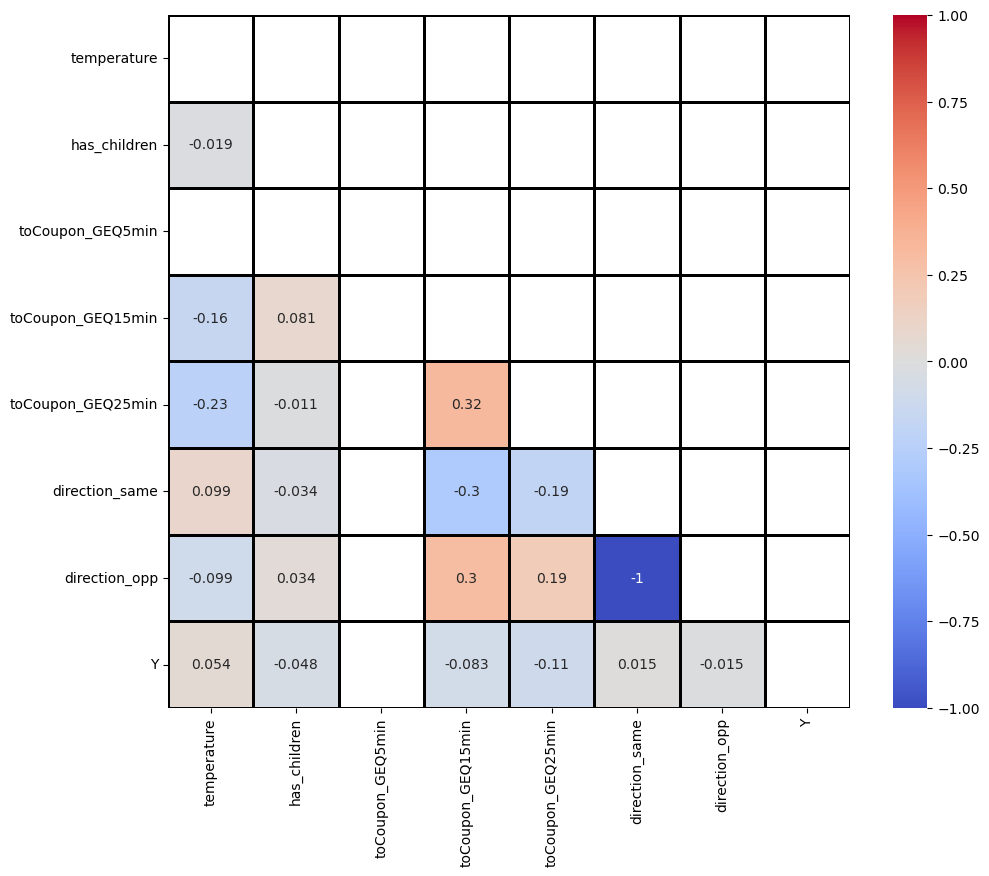

In [72]:
#https://stackoverflow.com/questions/57226054/seaborn-correlation-matrix-with-p-values-with-python
def plot_cor_matrix(corr, mask=None):
    f, ax = plt.subplots(figsize=(11, 9))
    sns.heatmap(corr, ax=ax,
                mask=mask,
                # cosmetics
                annot=True, vmin=-1, vmax=1, center=0,
                cmap='coolwarm', linewidths=2, linecolor='black', cbar_kws={'orientation': 'vertical'})
plot_cor_matrix(corr,mask)
plt.show()

In [74]:
X = X.drop(['direction_opp', 'toCoupon_GEQ5min'], axis = 1)# dropping these two columns

In [76]:
X_encoded = pd.get_dummies(X, columns=X.columns, drop_first=True, dtype = int)# one-hot encoding
X_encoded.head()

,destination_No Urgent Place,destination_Work,passenger_Friend(s),passenger_Kid(s),passenger_Partner,weather_Snowy,weather_Sunny,temperature_55,temperature_80,time_10PM,...,RestaurantLessThan20_gt8,RestaurantLessThan20_less1,RestaurantLessThan20_never,Restaurant20To50_4~8,Restaurant20To50_gt8,Restaurant20To50_less1,Restaurant20To50_never,toCoupon_GEQ15min_1,toCoupon_GEQ25min_1,direction_same_1
22,1,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
23,1,0,1,0,0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
24,1,0,1,0,0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
25,1,0,1,0,0,0,1,0,1,0,...,0,0,0,0,0,1,0,1,0,0
26,1,0,1,0,0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [78]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_encoded, y, test_size=0.4, random_state=1, stratify= y)

In [84]:
# saving train test split data to be used with XGBoost algorithm separately
X_train_.to_csv('X_train_.csv', index = False)
X_test_.to_csv('X_test_.csv', index = False)
y_test_.to_csv('y_test_.csv', index = False)
y_train_.to_csv('y_train_.csv', index = False)

Train Accuracy : 0.7012932832707551 and test accuracy 0.6843971631205674


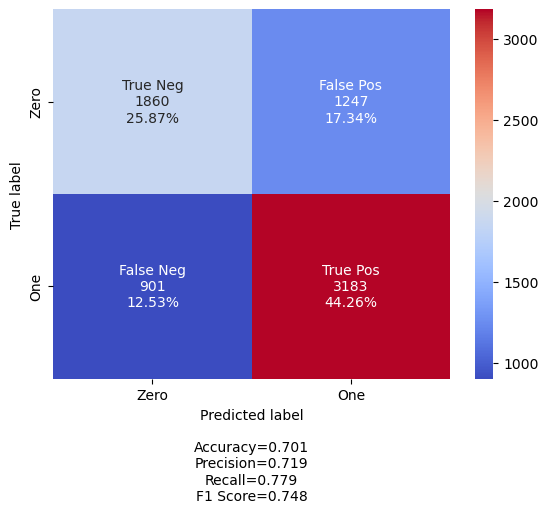

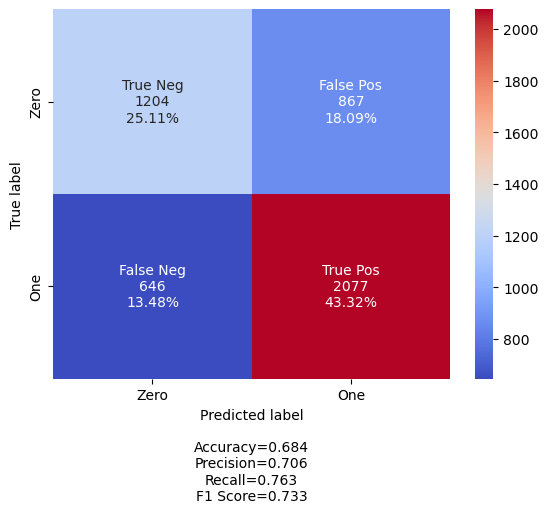

In [86]:
model = LogisticRegression()# create logistic regression
model.fit(X_train_, y_train_)# fitting model
y_test_acc = model.predict(X_test_)# predicting test data
y_train_acc = model.predict(X_train_)# training data predictions
print('Train Accuracy : {} and test accuracy {}'.format(accuracy_score(y_train_acc,y_train_),accuracy_score(y_test_acc,y_test_)))# accuracy calculation
cf_matrix_train = confusion_matrix(y_train_, y_train_acc)# train confusion matrix
cf_matrix_test = confusion_matrix(y_test_, y_test_acc)# test confusion matrix
labels = ['True Neg','False Pos','False Neg','True Pos']# labels for confusion matrix
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix_train, 
                      group_names=labels,
                      categories=categories, 
                      cmap='coolwarm')

make_confusion_matrix(cf_matrix_test, 
                      group_names=labels,
                      categories=categories, 
                      cmap='coolwarm')

Train Accuracy : 0.7010151578361841 and test accuracy 0.6839799749687109
              precision    recall  f1-score   support

           0       0.65      0.58      0.61      2071
           1       0.71      0.76      0.73      2723

    accuracy                           0.68      4794
   macro avg       0.68      0.67      0.67      4794
weighted avg       0.68      0.68      0.68      4794



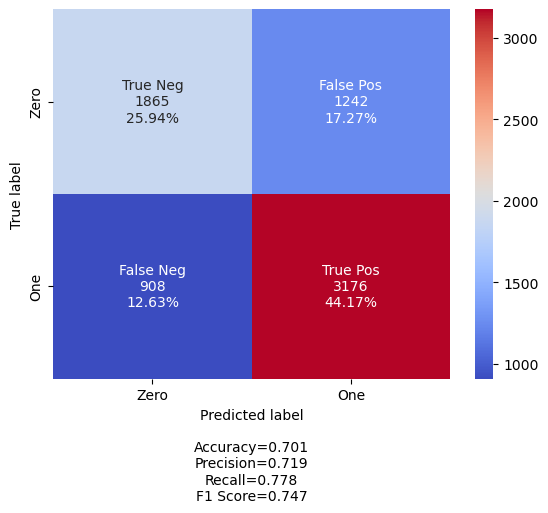

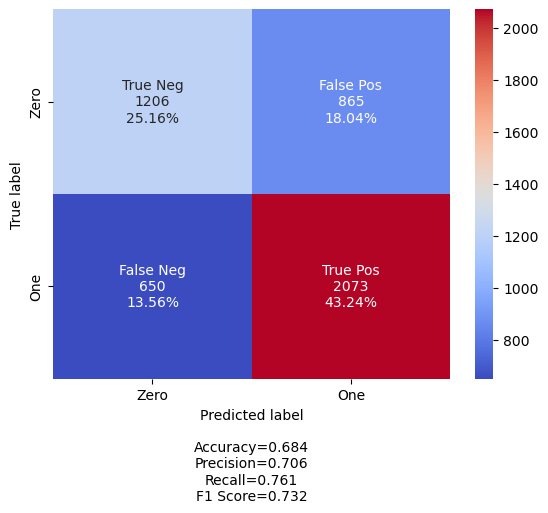

In [88]:
param_grid = [
    {'C' : np.logspace(-10,100,20),}]# grid for C parameters to control regularization
clf = GridSearchCV(model ,param_grid = param_grid, cv= 5)# grid search for hyper parameter tuning, to save tuning time CV is not used. However it is highly recommended to use it
best_clf = clf.fit(X_train_,y_train_)
model = LogisticRegression(C = best_clf.best_params_['C']) # using best parameter found through tuning
model.fit(X_train_, y_train_)# model fitting
y_test_acc = model.predict(X_test_)# test prediction
y_train_acc = model.predict(X_train_)# train prediction
print('Train Accuracy : {} and test accuracy {}'.format(accuracy_score(y_train_acc,y_train_),accuracy_score(y_test_acc,y_test_)))
print(classification_report(y_test_, y_test_acc))# classification report
cf_matrix_train_log = confusion_matrix(y_train_, y_train_acc)# confusion matrix train
cf_matrix_test_log = confusion_matrix(y_test_, y_test_acc)# confusion matrix test
labels = ['True Neg','False Pos','False Neg','True Pos']# labels for confusion matrix
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix_train_log, 
                      group_names=labels,
                      categories=categories, 
                      cmap='coolwarm')

make_confusion_matrix(cf_matrix_test_log, 
                      group_names=labels,
                      categories=categories, 
                      cmap='coolwarm')

Train Accuracy : 0.9929078014184397 and test accuracy 0.7000417188151856


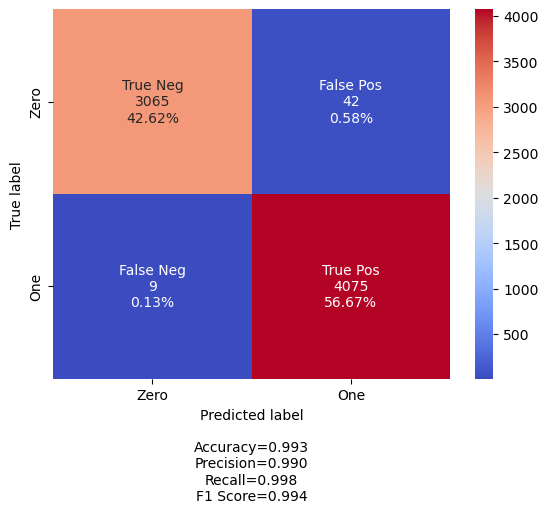

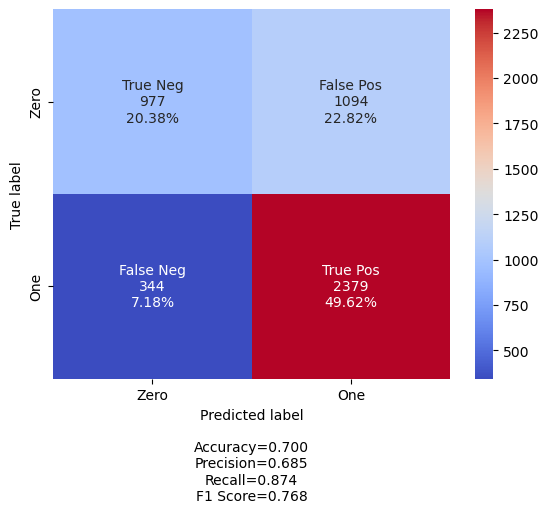

In [90]:
rbf = svm.SVC(kernel='rbf', gamma=0.5, C=1).fit(X_train_, y_train_)
y_test_acc_svm = rbf.predict(X_test_)
y_train_acc_svm = rbf.predict(X_train_)
print('Train Accuracy : {} and test accuracy {}'.format(accuracy_score(y_train_acc_svm,y_train_),accuracy_score(y_test_acc_svm,y_test_)))
cf_matrix_train_svm = confusion_matrix(y_train_, y_train_acc_svm)# calculating confusion matrix for train set
cf_matrix_test_svm = confusion_matrix(y_test_, y_test_acc_svm)# calculating confusion matrix for test set
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix_train_svm, 
                      group_names=labels,
                      categories=categories, 
                      cmap='coolwarm')

make_confusion_matrix(cf_matrix_test_svm, 
                      group_names=labels,
                      categories=categories, 
                      cmap='coolwarm')

In [92]:
def initialize_model(train_x, train_y):
    # create a single-task exact GP model instance
    # use a GP prior with Matern kernel and constant mean function by default
    model = SingleTaskGP(train_X=train_x, train_Y=train_y)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)

    return mll, model

In [94]:
torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double

In [96]:
def opt_acq_func(qEI, bounds, q = 1, num_restarts = 100, raw_samples=100):
    new_point_analytic, _ = optimize_acqf(
        acq_function=qEI, # acquisition function to guide the search
        bounds=bounds, # 6d unit hypercube
        q=q, # generate one candidate location in each iteration
        num_restarts=num_restarts, # number of starting points for multistart optimization
        raw_samples=raw_samples, # number of samples for initialization
        options={}, # additional options if any
    )
    return new_point_analytic

In [100]:
initial_c = np.array([100, 10000]).reshape(-1,1)# initial values of regularization C
initial_gamma = np.array([0.001, 1]).reshape(-1,1) # initial values of gamma
bounds = torch.tensor([[0.0] * 2, [1.0] * 2]) # bounds for both hyper params
scaler = MinMaxScaler() 
gamma_scaled = scaler.fit_transform(initial_gamma) # scaling gamma between 0-1
scaler_C = MinMaxScaler()
C_scaled = scaler_C.fit_transform(initial_c)# scaling C between 0-1
iterations = 20 # max iterations for tuning 
C = list(C_scaled) # creating list of C
gamma = list(gamma_scaled) # creating list of gamma
X_train_svm, X_val_svm, y_train_svm, y_val_svm = train_test_split(X_train_, y_train_, test_size=0.15, random_state=1, stratify= y_train_)# splitting data further for SVM for cross validation during Bayesian Opt

In [108]:
accuracy_svm = []# empty list for accuracy
MC_SAMPLES = 256 #nr of MonteCarlo samples
qmc_sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES])) # sampling space using SobolSet
for i in range(iterations):
    if i < initial_gamma.shape[0]: # first sims 
        rbf = svm.SVC(kernel='rbf', gamma=initial_gamma[i][0], C=initial_c[i][0]).fit(X_train_svm, y_train_svm)
        rbf_pred_test = rbf.predict(X_val_svm)
        rbf_pred_train = rbf.predict(X_train_svm)
        accuracy_svm.append({'Val':accuracy_score(y_val_svm, rbf_pred_test), 'Train': accuracy_score(y_train_svm, rbf_pred_train)})
    else:
        X_opt = torch.from_numpy(np.concatenate([np.array(C), np.array(gamma)], axis = 1)) # converting data to tensor
        test = np.array([i["Val"] for i in accuracy_svm])#test acuracy
        train = np.array([i["Train"] for i in accuracy_svm])# train accuracy
        y_opt = torch.from_numpy(((0.6*test)+(train*0.4))).reshape(-1,1)# weighted y_opt target to be used for optimization
        mll_qei, model_qei = initialize_model(X_opt, y_opt)# knowedge gradient model initialization
        fit_gpytorch_mll(mll_qei.cpu());#MLE fit
        mll_qei = mll_qei.to(X_opt)
        model_qei = model_qei.to(X_opt)
        qEI = qExpectedImprovement(
        model = model_qei, 
        best_f = y_opt.max(),
        sampler = qmc_sampler
        )# acquisition function
        candidates = opt_acq_func(qEI, bounds = bounds)# query candidates
        C.append(np.array([candidates.numpy()[0][0]]))# C parameters
        gamma.append(np.array([candidates.numpy()[0][1]])) # gamma parameter
        rbf = svm.SVC(kernel='rbf', gamma=scaler.inverse_transform(gamma)[-1][0], C=scaler_C.inverse_transform(C)[-1][0]).fit(X_train_svm, y_train_svm)
        rbf_pred_test = rbf.predict(X_val_svm)
        rbf_pred_train = rbf.predict(X_train_svm)
        accuracy_svm.append({'Val':accuracy_score(y_val_svm, rbf_pred_test), 'Train': accuracy_score(y_train_svm, rbf_pred_train)})
        print('Percentage Completed ', (i+1)/iterations*100)

Percentage Completed  15.0
Percentage Completed  20.0
Percentage Completed  25.0
Percentage Completed  30.0
Percentage Completed  35.0
Percentage Completed  40.0
Percentage Completed  45.0
Percentage Completed  50.0
Percentage Completed  55.00000000000001
Percentage Completed  60.0
Percentage Completed  65.0
Percentage Completed  70.0
Percentage Completed  75.0
Percentage Completed  80.0
Percentage Completed  85.0
Percentage Completed  90.0
Percentage Completed  95.0
Percentage Completed  100.0


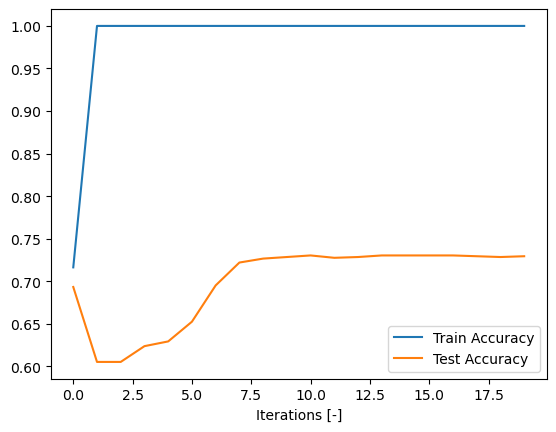

In [110]:
test_accuracy = [i["Val"] for i in accuracy_svm]
train_accuracy = [i["Train"] for i in accuracy_svm]
plt.plot(train_accuracy)
plt.plot(test_accuracy)
plt.xlabel('Iterations [-]')
plt.legend(['Train Accuracy', 'Test Accuracy'])

In [114]:
best_gamma = scaler.inverse_transform(gamma)[8]# using the above plot, choosing the 8th iteration as the best
best_C = scaler_C.inverse_transform(C)[8]# using the above plot, choosing the 8th iteration as the best
rbf = svm.SVC(kernel='rbf', gamma=best_gamma[0], C=best_C[0]).fit(X_train_svm, y_train_svm)# training on the SVM train data
rbf_pred_test = rbf.predict(X_test_)
rbf_pred_train = rbf.predict(X_train_svm)

Train Accuracy : 1.0 and test accuracy 0.7254901960784313


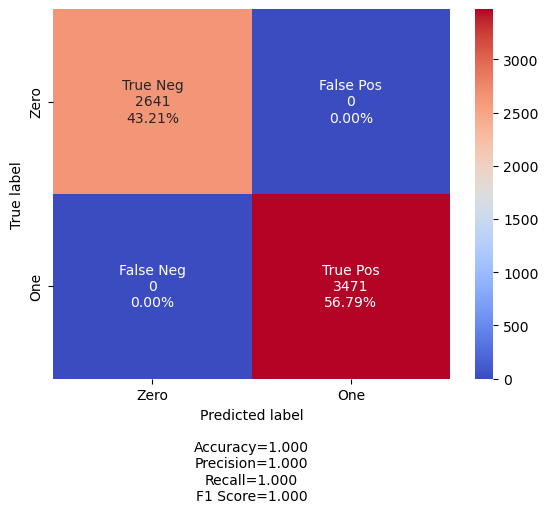

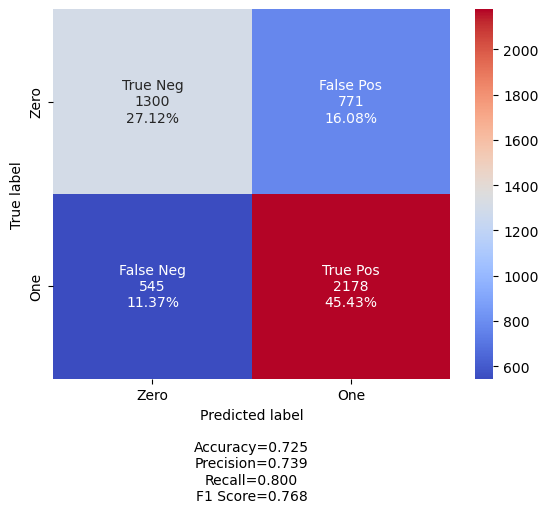

In [118]:
y_test_acc_svm = rbf.predict(X_test_)
y_train_acc_svm = rbf.predict(X_train_svm)
print('Train Accuracy : {} and test accuracy {}'.format(accuracy_score(y_train_acc_svm,y_train_svm),accuracy_score(y_test_acc_svm,y_test_)))
cf_matrix_train_svm = confusion_matrix(y_train_svm, y_train_acc_svm)
cf_matrix_test_svm = confusion_matrix(y_test_, y_test_acc_svm)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix_train_svm, 
                      group_names=labels,
                      categories=categories, 
                      cmap='coolwarm')

make_confusion_matrix(cf_matrix_test_svm, 
                      group_names=labels,
                      categories=categories, 
                      cmap='coolwarm')

In [122]:
#SVM model compute tp, tp_and_fn and tp_and_fp w.r.t all classes for test data svm
tp_and_fn = cf_matrix_test_svm.sum(1)
tp_and_fp = cf_matrix_test_svm.sum(0)
tp = cf_matrix_test_svm.diagonal()

precision_svm = tp[1] / tp_and_fp[1]
recall_svm = tp[1] / tp_and_fn[1]
accuracy_svm = accuracy_score(y_test_acc_svm,y_test_)

fpr1_svm, tpr1_svm, thresholds_svm = roc_curve(y_test_, y_test_acc_svm)
auc_svm = roc_auc_score(y_test_, y_test_acc_svm)

In [124]:
#Logistic Regression compute tp, tp_and_fn and tp_and_fp w.r.t all classes for test data logistic regression
tp_and_fn = cf_matrix_test_log.sum(1)
tp_and_fp = cf_matrix_test_svm.sum(0)
tp = cf_matrix_test_svm.diagonal()

precision_log = tp[1] / tp_and_fp[1]
recall_log = tp[1] / tp_and_fn[1]
accuracy_log = accuracy_score(y_test_acc,y_test_)
fpr1_log, tpr1_log, thresholds_log = roc_curve(y_test_, y_test_acc)
auc_log = roc_auc_score(y_test_, y_test_acc)

In [126]:
# get XGBoost results
y_pred_XGBoost = np.load('y_test_pred_XGBoost.npy')
cf_matrix_test_XGBoost = confusion_matrix(y_test_, y_pred_XGBoost)
tp_and_fn = cf_matrix_test_XGBoost.sum(1)
tp_and_fp = cf_matrix_test_XGBoost.sum(0)
tp = cf_matrix_test_svm.diagonal()

precision_XGBoost = tp[1] / tp_and_fp[1]
recall_XGBoost = tp[1] / tp_and_fn[1]
accuracy_XGBoost = accuracy_score(y_pred_XGBoost,y_test_)

fpr1_XG, tpr1_XG, thresholds_XG = roc_curve(y_test_, y_pred_XGBoost)
auc_XG = roc_auc_score(y_test_, y_pred_XGBoost)

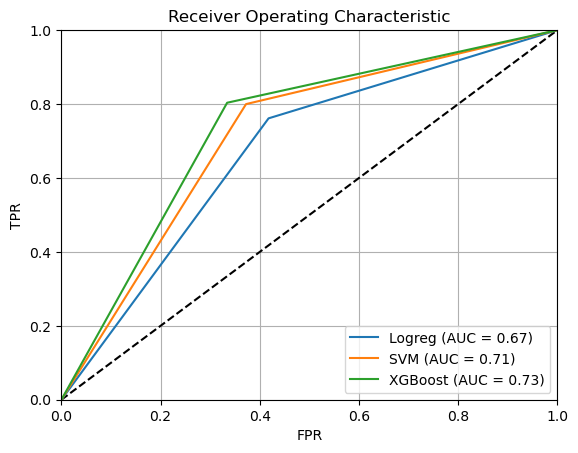

<Figure size 640x480 with 0 Axes>

In [128]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1_log, tpr1_log, label="Logreg (AUC = %0.2f)" % auc_log)
plt.plot(fpr1_svm, tpr1_svm, label="SVM (AUC = %0.2f)" % auc_svm)
plt.plot(fpr1_XG, tpr1_XG, label="XGBoost (AUC = %0.2f)" % auc_XG)
plt.grid()
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic')
plt.show()
plt.savefig('ROC.png')

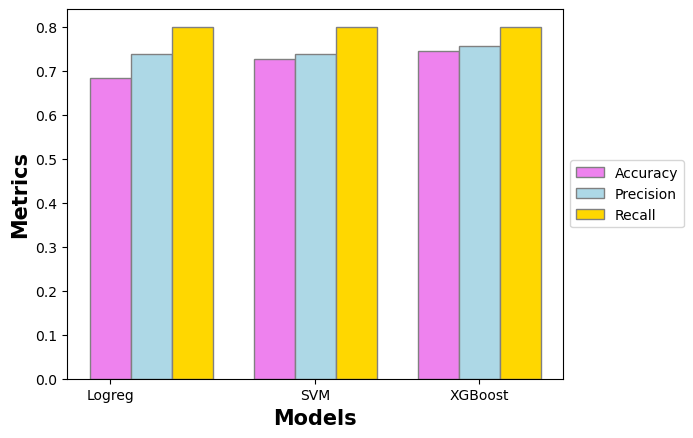

<Figure size 640x480 with 0 Axes>

In [130]:
accuracy = [accuracy_log, accuracy_svm, accuracy_XGBoost]# creating list for accuracy to be plotted
precision = [precision_log, precision_svm, precision_XGBoost] # creating list for precision
recall = [recall_log, recall_svm, recall_XGBoost]# creating list for recall

barWidth = 0.25
br1 = np.arange(len(accuracy)) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 

plt.bar(br1, accuracy, color ='violet', width = barWidth, 
        edgecolor ='grey', label ='Accuracy') 
plt.bar(br2, precision, color ='lightblue', width = barWidth, 
        edgecolor ='grey', label ='Precision') 
plt.bar(br3, recall, color ='gold', width = barWidth, 
        edgecolor ='grey', label ='Recall') 

plt.xlabel('Models', fontweight ='bold', fontsize = 15) 
plt.ylabel('Metrics', fontweight ='bold', fontsize = 15) 
plt.xticks([0, 1.25, 2.25],['Logreg', 'SVM', 'XGBoost'])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show() 
plt.savefig('Accuracy.png')